# Chapter 15: Cluster Analysis


> (c) 2019-2020 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.
>
> Date: 2020-03-08
>
> Python Version: 3.8.2
> Jupyter Notebook Version: 5.6.1
>
> Packages:
>   - matplotlib: 3.2.0
>   - numpy: 1.18.1
>   - pandas: 1.0.1
>   - scipy: 1.4.1
>   - scikit-learn: 0.22.2
>
> The assistance from Mr. Kuber Deokar and Ms. Anuja Kulkarni in preparing these solutions is gratefully acknowledged.


In [1]:
# Import required packages for this chapter
from pathlib import Path

import pandas as pd
import numpy as np
from pandas.plotting import parallel_coordinates
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

import matplotlib.pylab as plt

%matplotlib inline

In [2]:
# Working directory:
#
# We assume that data are kept in the same directory as the notebook. If you keep your 
# data in a different folder, replace the argument of the `Path`
DATA = Path('.')
# and then load data using 
#
# pd.read_csv(DATA / ‘filename.csv’)

# Problem 15.1: University Rankings
The dataset on American College and University Rankings (available from www.dataminingbook.com) contains information on 1302 American colleges and universities offering an undergraduate program. For each university, there are 17 measurements, including continuous measurements (such as tuition and graduation rate) and categorical measurements (such as location by state and whether it is a private or public school).

Note that many records  are missing some measurements. Our first goal is to estimate these missing values from "similar" records. This will be done by clustering the complete records and then finding the closest cluster for each of the partial records.  The missing values will be imputed from the information in that cluster.

## Solution 15.1.a
Remove all records with missing measurements from the dataset. 

In [3]:
# Load data
full_df = pd.read_csv(DATA / 'Universities.csv')

print('Before: ', full_df.shape)
universities_df = full_df.dropna(axis=0)
print('After: ', universities_df.shape)

universities_df.head()

Before:  (1302, 20)
After:  (471, 20)


,College Name,State,Public (1)/ Private (2),# appli. rec'd,# appl. accepted,# new stud. enrolled,% new stud. from top 10%,% new stud. from top 25%,# FT undergrad,# PT undergrad,in-state tuition,out-of-state tuition,room,board,add. fees,estim. book costs,estim. personal $,% fac. w/PHD,stud./fac. ratio,Graduation rate
0,Alaska Pacific University,AK,2,193.0,146.0,55.0,16.0,44.0,249.0,869.0,7560.0,7560.0,1620.0,2500.0,130.0,800.0,1500.0,76.0,11.9,15.0
2,University of Alaska Southeast,AK,1,146.0,117.0,89.0,4.0,24.0,492.0,1849.0,1742.0,5226.0,2514.0,2250.0,34.0,500.0,1162.0,39.0,9.5,39.0
9,Birmingham-Southern College,AL,2,805.0,588.0,287.0,67.0,88.0,1376.0,207.0,11660.0,11660.0,2050.0,2430.0,120.0,400.0,900.0,74.0,14.0,72.0
11,Huntingdon College,AL,2,608.0,520.0,127.0,26.0,47.0,538.0,126.0,8080.0,8080.0,1380.0,2540.0,100.0,500.0,1100.0,63.0,11.4,44.0
21,Talladega College,AL,2,4414.0,1500.0,335.0,30.0,60.0,908.0,119.0,5666.0,5666.0,1424.0,1540.0,418.0,1000.0,1400.0,56.0,15.5,46.0


## Solution 15.1.b
For all the continuous measurements, run hierarchical clustering using complete linkage and Euclidean distance. Make sure to normalize the measurements. From the dendrogram: How many clusters seem reasonable for describing these data?

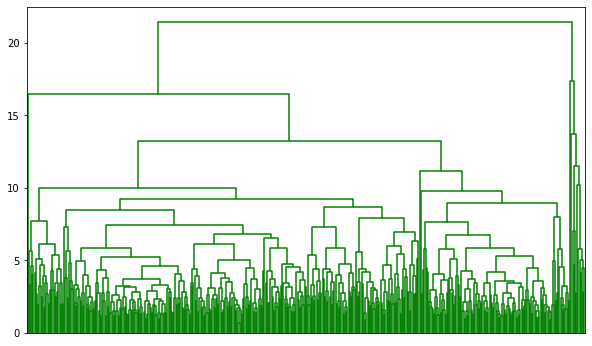

In [4]:
# Reduce to continuous measurements and normalize data
reduced_df = universities_df.drop(columns=['College Name', 'State', 'Public (1)/ Private (2)'])
universities_norm = (reduced_df - reduced_df.mean()) / reduced_df.std()

# Hierarchical clustering using complete linkage and Euclidean distance 
Z = linkage(universities_norm, method='complete', metric='euclidean')
fig = plt.figure(figsize=(10, 6))
dendrogram(Z, no_labels=True, color_threshold=55)
plt.show()

In [5]:
# try splitting into different number of clustesr
memb = fcluster(Z, 2, criterion='maxclust')
np.unique(memb, return_counts=True)

(array([1, 2], dtype=int32), array([458,  13]))

In [6]:
np.unique(fcluster(Z, 4, criterion='maxclust'), return_counts=True)

(array([1, 2, 3, 4], dtype=int32), array([457,   1,  12,   1]))

If we select #clusters = 2, we have on big cluster and one small cluster.
Looking at the same dendrogram, we see that 4 clusters is also a possibility,
on similar grounds. The following analysis is for 2 clusters, but a similar 
analysis could be conducted for different number of clusters.

## Solution 15.1.c
Compare the summary statistics for each cluster and describe each cluster in this context (e.g., "Universities with high tuition, low acceptance rate...").  (_Hint_: To obtain cluster statistics for hierarchical clustering, use the pandas method _groupby(clusterlabel)_ together with methods such as _mean_ or _median_.) 

In [7]:
centroids = {}
for key, item in reduced_df.groupby(memb):
    centroids['Cluster {}'.format(key)] = item.mean()

pd.DataFrame(centroids).round(2)

,Cluster 1,Cluster 2
# appli. rec'd,2747.43,17235.23
# appl. accepted,1790.03,11678.38
# new stud. enrolled,683.45,4207.00
% new stud. from top 10%,27.81,35.15
% new stud. from top 25%,55.27,69.08
# FT undergrad,3078.83,20618.54
# PT undergrad,684.05,4792.69
in-state tuition,9480.30,6811.38
out-of-state tuition,10579.12,10435.54
room,2214.19,2464.85


Cluster 2 contains universities with high enrollment numbers, higher college entrance exam scores, and lower tuition fees. Cluster 1 contains universities with lower enrollment numbers and higher tuition fees. Other numbers are comparable.

## Solution 15.1.d
Use the categorical measurements that were not used in the analysis (State and Private/Public) to characterize the different clusters. Is there any relationship between the clusters and the  categorical information?

In [8]:
for key, item in universities_df.groupby(memb):
    print('Cluster {}'.format(key))
    print(item['Public (1)/ Private (2)'].value_counts().sort_index())

Cluster 1
1    119
2    339
Name: Public (1)/ Private (2), dtype: int64
Cluster 2
1    9
2    4
Name: Public (1)/ Private (2), dtype: int64


Cluster 2 is predominantly public, cluster 1 private.

In [9]:
for key, item in universities_df.groupby(memb):
    print('Cluster {}'.format(key))
    print(item.State.value_counts())

Cluster 1
PA    41
NY    37
OH    24
NC    23
MA    19
IA    18
TX    18
TN    15
MO    15
VA    15
IN    15
IL    14
CA    14
NJ    12
MI    12
MN    10
CT    10
WI     9
SC     9
FL     8
GA     7
NE     7
VT     7
KS     7
OK     6
NH     6
ME     6
KY     6
CO     6
ND     5
LA     5
MS     5
OR     5
AR     4
DC     4
AL     4
RI     4
SD     4
MD     3
NM     2
ID     2
MT     2
WA     2
WV     2
AK     2
UT     2
DE     2
WY     1
HI     1
AZ     1
Name: State, dtype: int64
Cluster 2
MA    3
TX    2
NY    1
CA    1
NJ    1
PA    1
IL    1
MI    1
AZ    1
MN    1
Name: State, dtype: int64


There is no real geographic pattern.

## Solution 15.1.e
What other external information can explain the contents of some or all of these clusters?

State, not being a numeric variable, is not included in the clustering criteria. Note that southern states are under-represented in cluster 1 compared to cluster 2, and New England states are under-represented in cluster 2. Each group tends to have distinctive social and cultural norms. For example, sports receives relatively greater influence in the south than in New England. New England is known for its private college preparatory schools (particularly its elite ones) that feed students into selective (usually private and, hence, unsubsidized) universities. These factors could contribute to the higher cost and higher college entrance exam scores of cluster 1.

Recall that all variables must be present for a school to be included in the clustering process. Note that most of the Ivy League and several other key top schools are missing - this could be because they choose not to report some of the data used in the US News rankings. Since these schools are missing in the "cluster-building" phase, it is possible that our set of clusters is incomplete. So, our set of clusters may be incomplete.

There may be other factors as well that could inform our clustering process.

## Solution 15.1.f
Consider Tufts University, which is missing some information. Compute the Euclidean distance of this record from  each of the clusters that you found above (using only the measurements that you have). Which cluster is it closest to? Impute the missing values for Tufts by taking the average of the cluster on those measurements.

In [10]:
# Determine the cluster centroids
centroids = universities_norm.groupby(memb).mean()
centroids

,# appli. rec'd,# appl. accepted,# new stud. enrolled,% new stud. from top 10%,% new stud. from top 25%,# FT undergrad,# PT undergrad,in-state tuition,out-of-state tuition,room,board,add. fees,estim. book costs,estim. personal $,% fac. w/PHD,stud./fac. ratio,Graduation rate
1,-0.098174,-0.109007,-0.106214,-0.010969,-0.018749,-0.103681,-0.073362,0.013353,0.000919,-0.009701,-0.014139,-0.026271,-0.006233,-0.025678,-0.020739,-0.014720,0.001361
2,3.458740,3.840407,3.741995,0.386440,0.660544,3.652768,2.584582,-0.470427,-0.032383,0.341758,0.498124,0.925554,0.219578,0.904644,0.730637,0.518609,-0.047960


In [11]:
# Get information for 'Tufts University' and drop the non continuous variables
tufts_university = full_df.loc[full_df['College Name'] == 'Tufts University', :]
tufts_university = tufts_university.drop(columns=['College Name', 'State', 'Public (1)/ Private (2)'])

# Apply the same normalization as for reduced_df
tufts_norm = (tufts_university - reduced_df.mean())/reduced_df.std()

# Combine with the centroids information from the clustering
combined = tufts_norm.append(centroids)
combined

,# appli. rec'd,# appl. accepted,# new stud. enrolled,% new stud. from top 10%,% new stud. from top 25%,# FT undergrad,# PT undergrad,in-state tuition,out-of-state tuition,room,board,add. fees,estim. book costs,estim. personal $,% fac. w/PHD,stud./fac. ratio,Graduation rate
475,1.096623,0.615893,0.463390,1.730988,1.690004,0.221677,NaN,1.866005,2.116543,1.145408,1.425498,0.348397,0.313855,-0.563089,1.547610,-0.939412,1.456852
1,-0.098174,-0.109007,-0.106214,-0.010969,-0.018749,-0.103681,-0.073362,0.013353,0.000919,-0.009701,-0.014139,-0.026271,-0.006233,-0.025678,-0.020739,-0.014720,0.001361
2,3.458740,3.840407,3.741995,0.386440,0.660544,3.652768,2.584582,-0.470427,-0.032383,0.341758,0.498124,0.925554,0.219578,0.904644,0.730637,0.518609,-0.047960


In [12]:
# Calculate distance matrix dropping the columns containing NaN
d = pairwise.pairwise_distances(combined.dropna(axis=1), metric='euclidean')
pd.DataFrame(d, columns=combined.index, index=combined.index).head(5)

,475,1,2
475,0.000000,5.061369,7.778365
1,5.061369,0.000000,7.815593
2,7.778365,7.815593,0.000000


The distance to cluster 1 is 5.06 (normalized), and to cluster 2 it is 7.8. Tufts is closer to cluster 1. We can therefore imput the missing value for `# PT undergrad` in `tufts_norm`.

In [13]:
tufts_norm['# PT undergrad'] = centroids.loc[1, '# PT undergrad']
tufts_norm

,# appli. rec'd,# appl. accepted,# new stud. enrolled,% new stud. from top 10%,% new stud. from top 25%,# FT undergrad,# PT undergrad,in-state tuition,out-of-state tuition,room,board,add. fees,estim. book costs,estim. personal $,% fac. w/PHD,stud./fac. ratio,Graduation rate
475,1.096623,0.615893,0.46339,1.730988,1.690004,0.221677,-0.073362,1.866005,2.116543,1.145408,1.425498,0.348397,0.313855,-0.563089,1.54761,-0.939412,1.456852


# Problem 15.2: Pharmaceutical Industry
An equities analyst is studying the pharmaceutical industry and would like your help in exploring and
understanding the financial data collected by her firm. Her main objective is to understand the structure of the pharmaceutical industry using some basic financial measures.

Financial data gathered on 21 firms in the pharmaceutical industry are available in the file _Pharmaceuticals.csv_. For each firm, the following variables are recorded:

1. Market capitalization (in billions of dollars)
2. Beta
3. Price/earnings ratio
4. Return on equity
5. Return on assets
6. Asset turnover
7. Leverage
8. Estimated revenue growth
9. Net profit margin
10. Median recommendation (across major brokerages)
11. Location of firm's headquarters
12. Stock exchange on which the firm is listed


Use cluster analysis to explore and analyze the given dataset as follows:

## Solution 15.2.a
Use only the numerical variables (1-9) to cluster the 21 firms.  Justify the various choices made in conducting the cluster analysis, such as weights for different variables,  the specific clustering algorithm(s) used, the number of clusters formed, and so on.

In [14]:
# Load data, use the column Company as row names
pharma_df = pd.read_csv(DATA / 'Pharmaceuticals.csv')
pharma_df.set_index('Symbol', inplace=True)
pharma_df.head()

,Name,Market_Cap,Beta,PE_Ratio,ROE,ROA,Asset_Turnover,Leverage,Rev_Growth,Net_Profit_Margin,Median_Recommendation,Location,Exchange
Symbol,,,,,,,,,,,,,
ABT,Abbott Laboratories,68.44,0.32,24.7,26.4,11.8,0.7,0.42,7.54,16.1,Moderate Buy,US,NYSE
AGN,"Allergan, Inc.",7.58,0.41,82.5,12.9,5.5,0.9,0.60,9.16,5.5,Moderate Buy,CANADA,NYSE
AHM,Amersham plc,6.30,0.46,20.7,14.9,7.8,0.9,0.27,7.05,11.2,Strong Buy,UK,NYSE
AZN,AstraZeneca PLC,67.63,0.52,21.5,27.4,15.4,0.9,0.00,15.00,18.0,Moderate Sell,UK,NYSE
AVE,Aventis,47.16,0.32,20.1,21.8,7.5,0.6,0.34,26.81,12.9,Moderate Buy,FRANCE,NYSE


In [15]:
pharma_data = pharma_df.drop(columns=['Name', 'Median_Recommendation', 'Location', 'Exchange'])
pharma_data.head()

,Market_Cap,Beta,PE_Ratio,ROE,ROA,Asset_Turnover,Leverage,Rev_Growth,Net_Profit_Margin
Symbol,,,,,,,,,
ABT,68.44,0.32,24.7,26.4,11.8,0.7,0.42,7.54,16.1
AGN,7.58,0.41,82.5,12.9,5.5,0.9,0.60,9.16,5.5
AHM,6.30,0.46,20.7,14.9,7.8,0.9,0.27,7.05,11.2
AZN,67.63,0.52,21.5,27.4,15.4,0.9,0.00,15.00,18.0
AVE,47.16,0.32,20.1,21.8,7.5,0.6,0.34,26.81,12.9


Normalize: normalization gives the same importance to all the variables and so is important for distance calculations.

In [16]:
pharma_norm = pharma_data.apply(preprocessing.scale, axis=0)

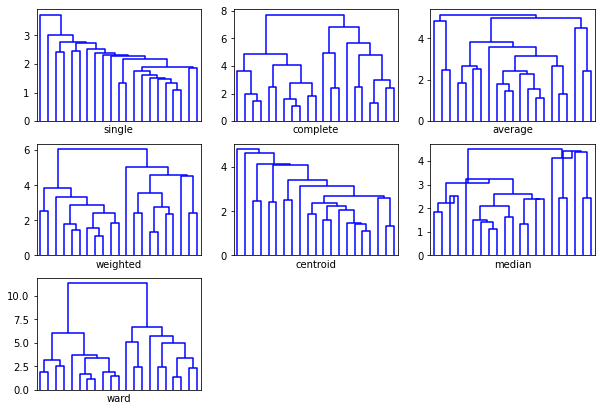

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 7), squeeze=False)
for i, method in enumerate(['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']):
    ax = axes[i // 3, i % 3]
    Z = linkage(pharma_norm, method=method)
    dendrogram(Z, color_threshold=0, ax=ax, no_labels=True)
    ax.set_xlabel(method)
fig.delaxes(axes[2,1])  # remove empty subplots
fig.delaxes(axes[2,2])

Ward clustering nicely separates the dataset into four clusters.

In [18]:
Z = linkage(pharma_norm, method='ward')
memb = fcluster(Z, 4, criterion='maxclust')

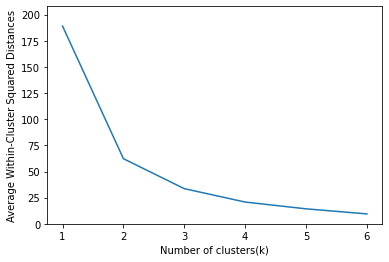

In [19]:
# k-means clustering
inertia = []
for n_clusters in range(1, 7):
    kmeans = KMeans(n_clusters=n_clusters, random_state=1).fit(pharma_norm)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(1, 7), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)
plt.show()

Three to four clusters seem to be a good choice

In [20]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(pharma_norm)

Two factors can help us decide how many clusters to form:

1. The purpose of the inquiry. How many clusters are we going to want to 
   deal with?
   In this case, to understand the structure of the industry in financial 
   terms we might use basic domain knowledge to consider that size and 
   financial performance are fundamental dimensions into which our various 
   metrics fall. To make sense of our analysis, we will need at least two 
   clusters, but more than 3 or 4 will probably defeat the purpose of 
   clustering, which is to simplify matters (at least for the purposes of
   initial analysis).

2. How do the clusters look when trying 2, 3, 4, 5 clusters? Are they nicely 
   separated? Do they have enough members to be useful? Do they look like
   natural clusters (as opposed to arbitrary decisions about cluster 
   membership)?
   Normalizing the data is important to ensure that the "distance measured" 
   accords equal weight to each variable. Without normalization, the variable
   with the largest scale will dominate the measure. 

Trying both k-means and hierarchical clustering, k-means of 3 and 4, and 
hierarchical clustering with Wards method give useful results. We will focus 
mainly on Wards clustering with k=4, but similar analysis could be made for the other
choices.

## Solution 15.2.b
Interpret the clusters with respect to the categorical variables used in forming the clusters.

In [21]:
centroids = {}
for key, item in pharma_data.groupby(memb):
    centroids['Cluster {}'.format(key)] = item.mean()

pd.DataFrame(centroids).round(2)

,Cluster 1,Cluster 2,Cluster 3,Cluster 4
Market_Cap,157.02,62.88,26.91,8.82
Beta,0.48,0.41,0.64,0.62
PE_Ratio,22.22,20.23,55.63,19.61
ROE,44.42,30.71,10.10,16.96
ROA,17.70,13.39,4.20,6.24
Asset_Turnover,0.95,0.71,0.70,0.54
Leverage,0.22,0.39,0.32,1.11
Rev_Growth,18.53,5.38,7.00,21.14
Net_Profit_Margin,19.58,20.51,5.13,13.19


- Cluster 1 companies are big, fast growing, profitable and not leveraged.
- Cluster 2 companies are of moderate size (market cap), profitable and slow growing, not leveraged.
- Cluster 3 companies are small, slow growing and of low profitability.
- Cluster 4 companies are small, fast growing, profitable and highly leveraged

## Solution 15.2.c
Is there a pattern in the clusters with respect to the numerical variables (10-12)? (those not used in forming the clusters).

In [22]:
pd.DataFrame(pd.Series(item.Median_Recommendation.value_counts(), name=f'Cluster {key}') 
             for key, item in pharma_df.groupby(memb))

,Hold,Moderate Buy,Moderate Sell,Strong Buy
Cluster 1,2.0,2.0,NaN,NaN
Cluster 2,4.0,1.0,2.0,NaN
Cluster 3,2.0,1.0,NaN,NaN
Cluster 4,1.0,3.0,2.0,1.0


With respect to buy/hold recommendations, clusters 2 and 4 are the interesting ones, 
characterized by mixed recommendations for each.  Cluster 4, for example, has
recommendations ranging from "moderate sell" to "strong buy".

In [23]:
pd.DataFrame(pd.Series(item.Location.value_counts(), name=f'Cluster {key}') 
             for key, item in pharma_df.groupby(memb))

,US,UK,SWITZERLAND,GERMANY,CANADA,IRELAND,FRANCE
Cluster 1,3.0,1.0,NaN,NaN,NaN,NaN,NaN
Cluster 2,5.0,1.0,1.0,NaN,NaN,NaN,NaN
Cluster 3,1.0,NaN,NaN,1.0,1.0,NaN,NaN
Cluster 4,4.0,1.0,NaN,NaN,NaN,1.0,1.0


With respect to country, the various countries are fairly well spread out across
the 4 clusters, though cluster 2 has 5 US firms.

In [24]:
pd.DataFrame(pd.Series(item.Exchange.value_counts(), name=f'Cluster {key}') 
             for key, item in pharma_df.groupby(memb))

,NYSE,NASDAQ,AMEX
Cluster 1,4.0,NaN,NaN
Cluster 2,7.0,NaN,NaN
Cluster 3,3.0,NaN,NaN
Cluster 4,5.0,1.0,1.0


With respect to exchange, there are only two non-NYSE firms in the data set, 
and they are in cluster 4, one of the "small firms" cluster. (This is 
consistent with the nature of the AMEX and NASDAQ, which typically host 
smaller firms than the NYSE.)

## Solution 15.2.d
Provide an appropriate name for each cluster using any or all of the variables in the dataset.

See PA3 week 2 discussion task

- Cluster 1: The big boys, financial stars
- Cluster 2: International establishment with decent financial performance.
- Cluster 3: Slow growth mid-size
- Cluster 4: Fast growth small-cap

# Problem 15.3: Customer Rating of Breakfast Cereals
The dataset _Cereals.csv_ includes nutritional information, store display, and consumer ratings for 77 breakfast cereals.

**Data preprocessing:** Remove all cereals with missing values.

In [25]:
cereals_df = pd.read_csv(DATA / 'Cereals.csv')

# drop rows with missing data
print('Before: ', cereals_df.shape)
cereals_nonmissing = cereals_df.dropna(axis=0)
print('After: ', cereals_nonmissing.shape)
cereals_nonmissing.head()

Before:  (77, 16)
After:  (74, 16)


,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,100%_Bran,N,C,70,4,1,130,10.0,5.0,6.0,280.0,25,3,1.0,0.33,68.402973
1,100%_Natural_Bran,Q,C,120,3,5,15,2.0,8.0,8.0,135.0,0,3,1.0,1.00,33.983679
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5.0,320.0,25,3,1.0,0.33,59.425505
3,All-Bran_with_Extra_Fiber,K,C,50,4,0,140,14.0,8.0,0.0,330.0,25,3,1.0,0.50,93.704912
5,Apple_Cinnamon_Cheerios,G,C,110,2,2,180,1.5,10.5,10.0,70.0,25,1,1.0,0.75,29.509541


## Solution 15.3.a
Apply hierarchical clustering to the data using Euclidean distance to the normalized measurements. Compare the dendrograms from single linkage and complete linkage, and look at cluster centroids. Comment on the structure of the clusters and on their stability. (_Hint_: To obtain cluster centroids for hierarchical clustering, compute the average values of each cluster members, using  _groupby()_ with the cluster centers followed by _mean_: _dataframe.groupby(clusterlabel).mean()_.)

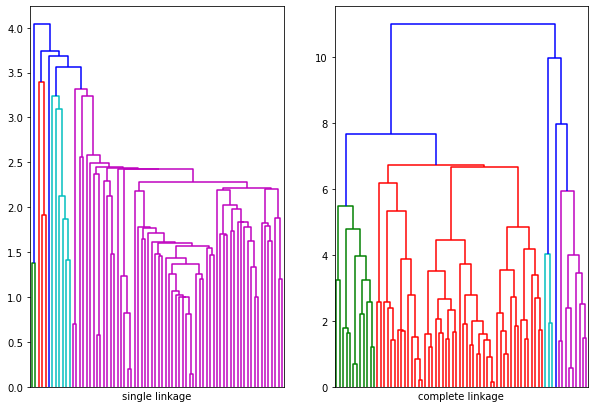

In [26]:
# normalize data
temp = cereals_nonmissing.drop(columns=['name', 'mfr', 'type'])
cereals_norm = (temp - temp.mean())/temp.std()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 7), squeeze=False)
for i, (method, threshold) in enumerate([('single', 3.5), ('complete', 7)]):
    ax = axes[0, i]
    Z = linkage(cereals_norm, method=method, metric='euclidean')
    dendrogram(Z, color_threshold=threshold, ax=ax, no_labels=True)
    ax.set_xlabel(method + ' linkage')

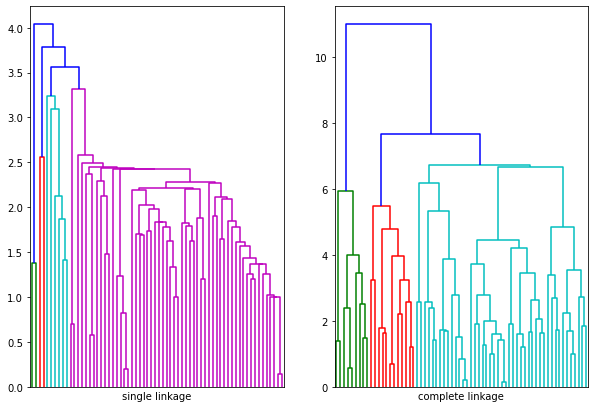

In [27]:
# redo clustering after removing data points from start and end of dataset
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 7), squeeze=False)
for i, (method, threshold) in enumerate([('single', 3.5), ('complete', 7)]):
    ax = axes[0, i]
    Z = linkage(cereals_norm.iloc[4:-4,:], method=method, metric='euclidean')
    dendrogram(Z, color_threshold=threshold, ax=ax, no_labels=True)
    ax.set_xlabel(method + ' linkage')

Clusters appear to be not well stabilized as removing some data resulted in different dendrograms.

## Solution 15.3.b
Which method leads to the most insightful or meaningful clusters?

Complete linkage leads to more insightful clusters.

## Solution 15.3.c
Choose one of the methods. How many clusters would you use? What distance is used for this cutoff? (Look at the dendrogram.)

We would use complete linkage method, cutting the dendrogram at around 7 to get 5 clusters.

## Solution 15.3.d
The elementary public schools would like to choose a set of cereals to include in their daily cafeterias. Every day a different cereal is offered, but all cereals should support a healthy diet. For this goal, you are requested to find a cluster of "healthy cereals." Should the data be normalized? If not, how should they be used in the cluster analysis?

In [28]:
Z = linkage(cereals_norm, method='ward', metric='euclidean')
memb = fcluster(Z, 5, criterion='maxclust')

centroids = {}
for key, item in cereals_nonmissing.groupby(memb):
    centroids['Cluster {}'.format(key)] = item.mean()

pd.DataFrame(centroids).round(2)

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
calories,63.33,124.00,110.95,82.22,103.81
protein,4.00,3.15,1.52,2.44,2.71
fat,0.67,1.95,1.00,0.11,0.52
sodium,176.67,155.00,172.38,1.67,226.19
fiber,11.00,3.10,0.57,2.11,1.67
carbo,6.67,13.95,12.62,15.33,18.48
sugars,3.67,9.35,11.29,2.33,3.33
potass,310.00,151.50,45.95,90.56,73.81
vitamins,25.00,31.25,25.00,11.11,39.29
shelf,3.00,2.90,1.67,2.00,2.10


The most deleterious attributes of breakfast cereals, particularly those for 
children, are high levels of salt and sugar.  Cluster 4 is the most health cluster 
in this respect.

# Problem 15.4: Marketing to Frequent Fliers
The file _EastWestAirlinesCluster.csv_ contains information on 3999 passengers who belong to an airline's frequent flier program. For each passenger, the data include information on their mileage history and on different ways they accrued or spent miles in the last year. The goal is to try to identify clusters of passengers that have similar characteristics for the purpose of targeting different segments for different types of mileage offers.

## Solution 15.4.a
Apply hierarchical clustering with Euclidean distance and Ward's method. Make sure to normalize the data first. How many clusters appear?

In [29]:
airlines_df = pd.read_csv(DATA / 'EastWestAirlinesCluster.csv')
airlines_df = airlines_df.set_index("ID#")
airlines_df.head()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
ID#,,,,,,,,,,,
1,28143,0,1,1,1,174,1,0,0,7000,0
2,19244,0,1,1,1,215,2,0,0,6968,0
3,41354,0,1,1,1,4123,4,0,0,7034,0
4,14776,0,1,1,1,500,1,0,0,6952,0
5,97752,0,4,1,1,43300,26,2077,4,6935,1


In [30]:
airlines_norm = (airlines_df - airlines_df.mean())/airlines_df.std()
airlines_norm.head()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
ID#,,,,,,,,,,,
1,-0.451084,-0.186275,-0.769482,-0.09823,-0.062759,-0.702698,-1.103926,-0.328562,-0.362123,1.395280,-0.766823
2,-0.539389,-0.186275,-0.769482,-0.09823,-0.062759,-0.701001,-0.999801,-0.328562,-0.362123,1.379784,-0.766823
3,-0.319991,-0.186275,-0.769482,-0.09823,-0.062759,-0.539185,-0.791550,-0.328562,-0.362123,1.411744,-0.766823
4,-0.583726,-0.186275,-0.769482,-0.09823,-0.062759,-0.689200,-1.103926,-0.328562,-0.362123,1.372037,-0.766823
5,0.239648,-0.186275,1.409295,-0.09823,-0.062759,1.082986,1.499207,1.154788,0.692404,1.363805,1.303755


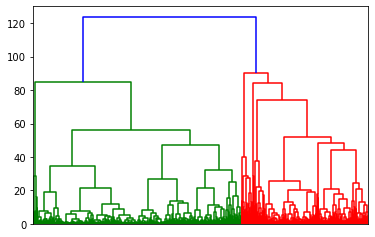

In [31]:
Z = linkage(airlines_norm, method='ward', metric='euclidean')
dendrogram(Z, color_threshold=100, no_labels=True)
plt.show()

The dataset can be split into two clusters.

## Solution 15.4.b
What would happen if the data were not normalized?

Normalizing the data is important to ensure that the "distance measured" 
accords equal weight to each variable - without normalization, the variable
with the largest scale will dominate the measure.
Here the variables that have the largest scale are Balance, Bonus_trans,
Fligt_miles_12mo, and Days_since_enroll. These variables will dominate the 
measure if we don't standardize the data.


## Solution 15.4.c
Compare the cluster centroid to characterize the different clusters, and try to give each cluster a label.

In [32]:
memb = fcluster(linkage(airlines_norm, method='ward', metric='euclidean'), 2, criterion='maxclust')
centroids = {}
for key, item in airlines_df.groupby(memb):
    centroids[key] = item.mean()
    print('Cluster {}: size {}'.format(key, len(item)))
pd.DataFrame(centroids).transpose()

Cluster 1: size 2489
Cluster 2: size 1510


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
1,46718.863399,9.274407,1.242266,1.023303,1.00000,5037.792688,7.091201,221.167135,0.700281,3772.785858,0.188027
2,117912.886093,366.377483,3.406623,1.000000,1.03245,37101.439735,19.037086,853.826490,2.483444,4688.513245,0.670861


Observing the cluster centroids we can see that Cluster 1 has lower values on 
virtually all variables. We can think of Cluster 1 as "occasional and minimal 
flyers" and Cluster 2 as "frequent and loyal travelers."


## Solution 15.4.d
To check the stability of the clusters, remove a random 5% of the data (by taking a random sample of 95\% of the records), and repeat the analysis. Does the same picture emerge?

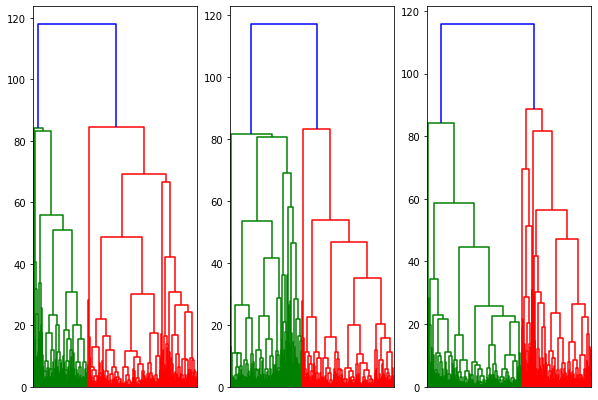

In [33]:
# we repeat the random sampling three times
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 7))
for ax in axes:
    Z = linkage(airlines_norm.sample(frac=0.95), method='ward', metric='euclidean')
    dendrogram(Z, color_threshold=100, ax=ax, no_labels=True)
plt.show()

The dendrogram looks a bit different, but the same conclusions result: 
clusters occur naturally at 2 clusters, and the characteristics of the
resulting clusters are similar to those in
the clusters found in the entire data set.

## Solution 15.4.e
Use $k$-means clustering with the number of clusters that you found above. Does the same picture emerge?

In [34]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(airlines_norm)

# Compare the cluster membership between k-means and hierarchical clustering
pd.crosstab(memb, kmeans.labels_)

col_0,0,1
row_0,,
1,2436,53
2,261,1249


The cluster membership from the two methods is comparable. 

In [35]:
centroids = {}
for key, item in airlines_df.groupby(kmeans.labels_):
    centroids[key] = item.mean()
    print('Cluster {}: size {}'.format(key, len(item)))
pd.DataFrame(centroids).transpose()

Cluster 0: size 2697
Cluster 1: size 1302


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,45041.650352,89.232481,1.310716,1.016685,1.000371,5421.404894,7.363737,215.211346,0.635521,3720.834631,0.206897
1,132760.658986,257.798771,3.610599,1.009985,1.036866,41429.117512,20.380952,967.233487,2.902458,4942.417819,0.708909


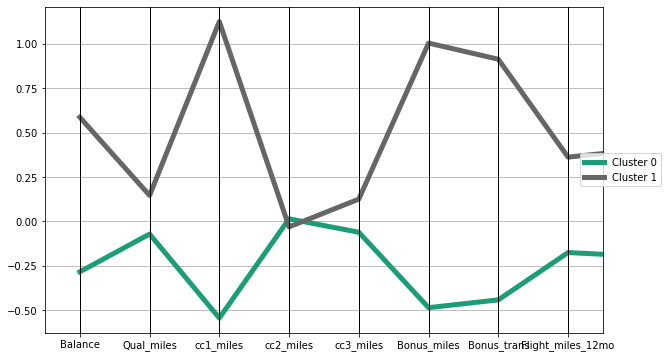

In [36]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=airlines_norm.columns)
centroids['cluster'] = ['Cluster {}'.format(i) for i in centroids.index]

plt.figure(figsize=(10,6))
fig.subplots_adjust(right=3)
ax = parallel_coordinates(centroids, class_column='cluster', colormap='Dark2', linewidth=5)
plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.5))
plt.xlim(-0.5,7.5)
plt.show()

## Solution 15.4.f
Which clusters would you target for offers, and what types of offers would you target to customers in that cluster?


For the "minimal, non-frequent" flyers, two types of offers might be used.
1. Offers to liquidate the mileage, to remove it as a liability (e.g., offers to purchase magazine subscriptions)
2. Offers for special mileage bonuses if a number of segments or miles is flown in a limited period of time, in case some of these flyers are regular customers of other airlines, or new flyers, in hopes that some of them will become more "invested" in East-West.

For the frequent, loyal flyer we might

1. Offer luxury goods in conjunction with partners (high end vacations, exclusive real estate, etc.) -- frequent flyers are likely to be relatively prosperous (compared to non-frequent flyers).
